# Интро

Целью данного проекта является создание аудио классификатора по типу Алексы и Алисы, который способен распозновать речевые единицы. К примеру, для данного проекта было выбрано распознавание пения птицы-капуцина в лесу с дождем.


Датасет для этого предоставила компания HP.


Для начала нужно найти путь конвертирования аудио (3-х секундные клипы) в числовые значения. Мы представим звук в качестве звуковой волны, далее мы конвертируем волну в спектрограмму (изображение, показывающее зависимость спектральной плотности мощности сигнала от времени) (простыми словами спектрограмма показывает на изображение силу звука, где на оси y - сила звука, а на оси x - время). 


Благодаря переводу в спектрограмму мы сможем использовать компьютерное зрение и сверточные нейронные сети для решения проблемы классификации. 


Далее мы строим сверточную нейронную сеть, а на выходе мы будем получать бинарные значения. 1 - если это нужный нам звук и 0 - если нужный звук не (уже будет более правильно сказать) "увиден".


Аудио клип для теста будет длиной три секунды. Наше задание - найти в данном клипе моменты, когда будет петь птица-капуцин. Для этого нам нужно будет разделить аудиоклип на 3-х секундные отрезки. Далее мы пропустим отрезки через модель, а после подсчитаем их кол-во.


Стоит отметить что в данном клипе будут присутствовать последовательные звуки пения, которые будут распознаны, как индивидуальные звуки пения. Мы будем распознавать такие звуки, собирать их в один и считать за один звук (подробное объяснение будет чуть позже).

# Установка окружения

In [31]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf 
import tensorflow_io as tfio

In [32]:
#не дает модели использовать более 0.333 оперативки, помогает если надо обучать несколько моделей сразу (к примеру, когда
#мы учили несколько моделей сразу играть в игру)
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.99)
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

# Загрузка данных

In [33]:
#определим пути для пробных данных
CAPUCHIN_FILE = os.path.join('data', 'Parsed_Capuchinbird_Clips', 'XC3776-3.wav')
NOT_CAPUCHIN_FILE = os.path.join('data', 'Parsed_Not_Capuchinbird_Clips', 'afternoon-birds-song-in-forest-0.wav')

In [34]:
#функция для загрузки звуковых данных в формате wav до 16к герц сэмпл рейта в моно 
def load_wav_16k_mono(filename):
    # Кодирует аудиофайл в string 
    file_contents = tf.io.read_file(filename)
    # Конвертирует аудио файл в Tensor и сохраняет его в wav
    #sample_rate - сообщает о качестве звука
    # desired_channels - конвертируем стерео в моно (для более просто обработки аудио + менее требовательный формат)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Убирает одно измеренеие и переводит array в 1-D измерение 
    wav = tf.squeeze(wav, axis=-1)
    #переводим из int32 в int64
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # перевод из 44100герц в 16000 для более простой и быстрой обработки данных. Таким образом аудио становится меньше по весу
    #и чуть хуже по качеству, но в наших целях пойдет и такой формат
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

In [35]:
#посмотрим на пробные данные
wave = load_wav_16k_mono(CAPUCHIN_FILE) #пение птиц
nwave = load_wav_16k_mono(NOT_CAPUCHIN_FILE) #отсутствие пения птиц

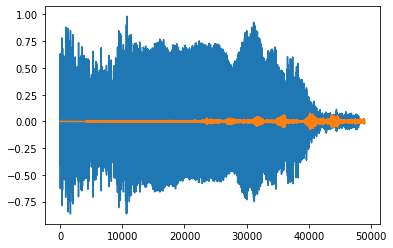

In [36]:
plt.plot(wave) #синим
plt.plot(nwave) #оранжевым
plt.show()

# Создание датасета

In [37]:
#Пропишем пути к позитивным и негативным данным
POS = os.path.join('data', 'Parsed_Capuchinbird_Clips')
NEG = os.path.join('data', 'Parsed_Not_Capuchinbird_Clips')

In [38]:
#создаем датасет. Проще говоря просто ищем файлы подходящего формата в заданных папках
pos = tf.data.Dataset.list_files(POS+'\*.wav') 
neg = tf.data.Dataset.list_files(NEG+'\*.wav')

In [39]:
#Перейдем к созданию лейблов
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)

# Определение средней длины пения птицы-капуцина

In [40]:
#создадим пустой лист в который будем отправлять значения длины аррэев записей пения птиц 
lengths = []
for file in os.listdir(os.path.join('data', 'Parsed_Capuchinbird_Clips')):
    tensor_wave = load_wav_16k_mono(os.path.join('data', 'Parsed_Capuchinbird_Clips', file))
    lengths.append(len(tensor_wave))

In [41]:
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=54156>

В одном файле в среднем 54156 значений, если разделить на значение герц (16000), то получим

In [42]:
print('Средняя длина пения птицы-капуцина = {} секунды'.format(54156/16000 )) 

Средняя длина пения птицы-капуцина = 3.38475 секунды


In [43]:
tf.math.reduce_min(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=32000>

In [44]:
print('Самая короткая длина пения птицы-капуцина = {} секунды'.format(32000/16000 )) 

Самая короткая длина пения птицы-капуцина = 2.0 секунды


In [45]:
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=80000>

In [46]:
print('Самая большая длина пения птицы-капуцина = {} секунды'.format(80000/16000 )) 

Самая большая длина пения птицы-капуцина = 5.0 секунды


# Конвертирование данных в спектрограммы (построение предобрабатывающей функции)

In [47]:
#построим функция для предобработки
#итерация через лейбл нужна т.к. tensorflow пайплан по предобработке (в который мы включим данную функцию)
#проходит через полный сэмпл (не только признаки, но и лейбл)
def preprocess(file_path, label): 
    wav = load_wav_16k_mono(file_path) #обрабатываем сэпмлы в нашей функции
    wav = wav[:48000] #из каждого сигнала берем только первые 48000 шагов (т.к. среднее 54156)
    #мы можем взять и до 80000 шагов, но тогда предобработка будет слишком долгая
    
    #Но не все сэпмлы достигают значения в 48000, некоторые сэмплы набирают только 32000 шагов, как помним.
    #В таком случае мы можем наполнить недостающие шаги 0-ми 
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32) #берем количество нулей, которое нужно
    wav = tf.concat([zero_padding, wav],0) #конкатенируем с сэпмлом
    
    #создаем спектрограмму
    #tf.signal.stft - оконное преобразование фурье - разбиение аудиосингнала на окна
    #frame_length - длина окна
    #frame_step - шаг в окне
    #Если у нас была форма аррэя 48000, то после преобразования она будет (1491, 257)
    #1491 - окон, по 257 шагов в каждом
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    #переводим в модули
    spectrogram = tf.abs(spectrogram)
    #Т.к. у нас будет сверточная нейронная сеть, то нам нужно перевести значения в форму ([1491, 257, 1]), т.к. данная сеть
    #ожидает получить на вход канальное измрение
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

# Визуализируем спектрограммы

In [48]:
#поместим позитивный сэмпл в переменные
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()

In [49]:
#применим функцию
spectrogram, label = preprocess(filepath, label)

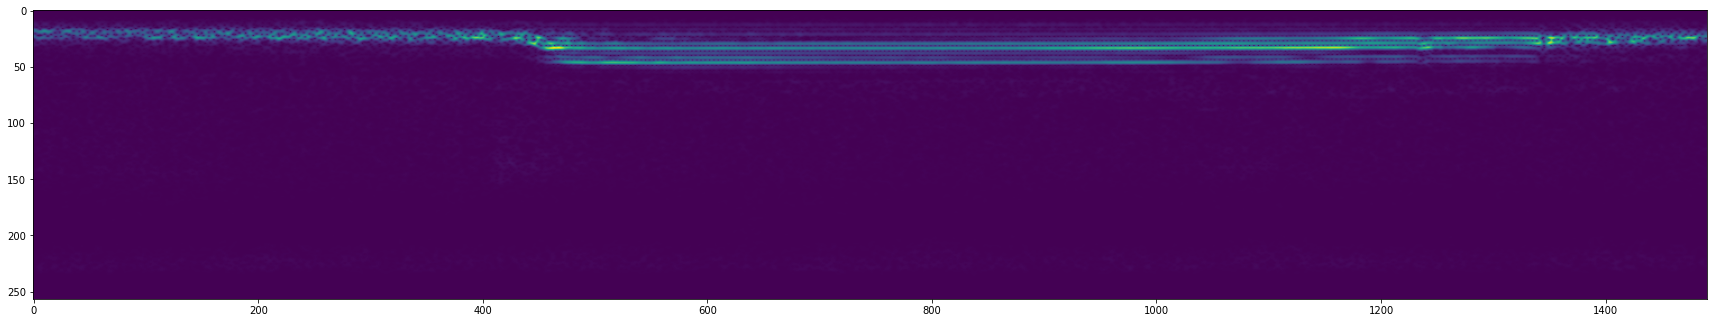

In [50]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
# spectrogram[0].shape = (257, 1) - берем только одно окно
plt.show()

Мы можем заметить, что пение птицы имеет определенный паттерн в своей форме: резкий скачек ближе к середине

# Предподготовка с помощью пайплайна

In [51]:
#Пайплайн с помощью тенсорфлоу
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

In [52]:
#Делим по батчам на тестовую и тренировочную выборки
train = data.take(36)
test = data.skip(36).take(15)

In [53]:
#посмотрим на один сэмпл
samples, labels = train.as_numpy_iterator().next()

In [54]:
samples.shape
#Получили 16 сэпмлов в батче, в каждом из сэмплов 1491 окно с 257 шагами

(16, 1491, 257, 1)

# Построение модели 

In [57]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D

In [58]:
#Инициализируем модель и её слои
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(1491, 257,1)))
model.add(MaxPooling2D(pool_size=(2,2)))
#16 - нейронов, 3*3 размер окна, input shape - форма сэпмла
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
#На этот момент аутпут из сверточных слоев будет в 3-D. перед тем как подать его на вход в обычный слой нам нужно будет
#сделать данные "плоскими" (перевести в 1-D)
model.add(Flatten())
model.add(Dense(128, activation='relu'))
#Слой с одним нейроном, т.к. всего будет 2 значения (0 или 1) 
model.add(Dense(1, activation='sigmoid'))

In [59]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [60]:
model.summary()
#получили довольно большую модель, чтобы скинуть параметры мы можем вставить MaxPooling слой между conv2d слоями
#что мы и сделаем 
#Таким образом удалось снизить кол-во параметров модели с 770 млн до 47 млн, тем самым увеличив скорость обучения без 
#малейшего вреда на показания метрик

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 1489, 255, 16)     160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 744, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_5 (Conv2D)           (None, 742, 125, 16)      2320      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 371, 62, 16)      0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 368032)            0         
                                                                 
 dense_2 (Dense)             (None, 128)              

In [61]:
hist = model.fit(train, epochs=4, validation_data=test)

Epoch 1/4
36/36 [==============================] - 87s 2s/step - loss: 0.7199 - recall_1: 0.8387 - precision_1: 0.8725 - val_loss: 0.1390 - val_recall_1: 0.9412 - val_precision_1: 0.9846
Epoch 2/4
36/36 [==============================] - 78s 2s/step - loss: 0.0651 - recall_1: 0.9795 - precision_1: 0.9862 - val_loss: 0.0098 - val_recall_1: 0.9815 - val_precision_1: 1.0000
Epoch 3/4
36/36 [==============================] - 77s 2s/step - loss: 0.0096 - recall_1: 0.9936 - precision_1: 0.9873 - val_loss: 0.0021 - val_recall_1: 1.0000 - val_precision_1: 1.0000
Epoch 4/4
36/36 [==============================] - 76s 2s/step - loss: 0.0021 - recall_1: 1.0000 - precision_1: 1.0000 - val_loss: 4.0834e-04 - val_recall_1: 1.0000 - val_precision_1: 1.0000


In [65]:
hist.history

{'loss': [0.7198818922042847,
  0.06510520726442337,
  0.009591978043317795,
  0.0020849115680903196],
 'recall_1': [0.8387096524238586, 0.9794520735740662, 0.9935897588729858, 1.0],
 'precision_1': [0.8724831938743591,
  0.9862068891525269,
  0.987261176109314,
  1.0],
 'val_loss': [0.13900116086006165,
  0.009834918193519115,
  0.0021371240727603436,
  0.00040833750972524285],
 'val_recall_1': [0.9411764740943909, 0.9814814925193787, 1.0, 1.0],
 'val_precision_1': [0.9846153855323792, 1.0, 1.0, 1.0]}

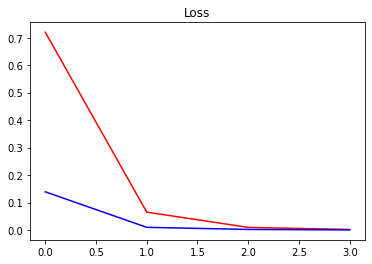

In [62]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

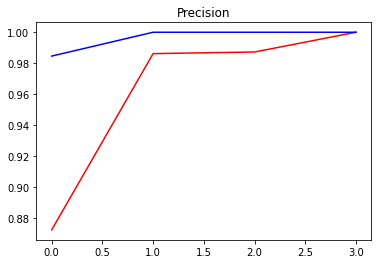

In [67]:
plt.title('Precision')
plt.plot(hist.history['precision_1'], 'r')
plt.plot(hist.history['val_precision_1'], 'b')
plt.show()

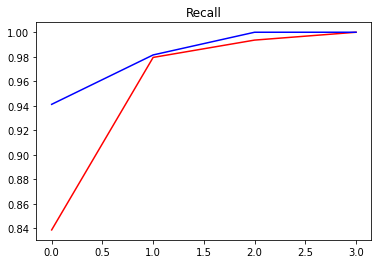

In [66]:
plt.title('Recall')
plt.plot(hist.history['recall_1'], 'r')
plt.plot(hist.history['val_recall_1'], 'b')
plt.show()

# Прогноз на одном сэмпле

In [68]:
#возьмем один батч 
X_test, y_test = test.as_numpy_iterator().next()

In [69]:
yhat = model.predict(X_test)

1/1 [==============================] - 1s 768ms/step


In [71]:
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

In [77]:
#Посмотрим сколько раз мы зафиксировали пение
tf.math.reduce_sum(yhat)

<tf.Tensor: shape=(), dtype=int32, numpy=6>

In [78]:
#Посмотрим сколько раз на самом деле пели птицы
tf.math.reduce_sum(y_test)

<tf.Tensor: shape=(), dtype=float32, numpy=6.0>

In [203]:
# сохраним модель
model.save('Capuchin_bird_model.h5')

In [204]:
#если нужно загрузить модель
model = tf.keras.models.load_model('Capuchin_bird_model.h5')

Мы правильно предсказали 6 из 6 раз

# Функция для парсинга звуков в тесте

In [163]:
#звуки для конечного теста не только различаются по длине, но и формате mp3 в отличии от звуков для трейна, которые были 
#в формате wav. Переделаем функцию

In [180]:
def load_mp3_16k_mono(filename):
    #Загружаем wav файл, конвертируем в аррэй, ресемплим в моно в 16к герц
    res = tfio.audio.AudioIOTensor(filename)
    # Конвертируем в аррэй и переводим тенсор
    tensor = res.to_tensor()
    # Складываем два канала и делим на 2 (получаем среднее)
    tensor = tf.math.reduce_sum(tensor, axis=1) / 2 
    # Получаем сэмпл рейт
    sample_rate = res.rate
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Ресемплим на 16к герц
    wav = tfio.audio.resample(tensor, rate_in=sample_rate, rate_out=16000)
    return wav

In [181]:
#проверим функцию на  однои из сэпмлов
mp3 = os.path.join('data', 'Forest Recordings', 'recording_00.mp3')

In [182]:
wav = load_mp3_16k_mono(mp3)

In [183]:
#в wav сейчас хранится длинный файл. Наша модель обучена распознавать в коротких звуках. Мы нарежем данный длинный файл 
#на куски, которые по размеру подходят для вхаоду в нашу нейронную сеть 
#Получается, что мы будем делать множество прогнозов на одном длинном клипе
#1 арг - на инпут
#2 арг -  таргет
#3 арг -  на сколько длинным должен быть кусок
#4 арг -  шаг по обрезанию (через сколько резать новый кусок). Мы делаем длину такой же как и длину куска, чтобы
#куски не накладывались дргу на друга. 
#4 арг - размер батча
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000,
                                                            sequence_stride=48000, batch_size=1)

In [184]:
len(audio_slices)
#Таким образом мы поделили один длинный кусок на 60 маленьких 

60

In [185]:
#получаем один батч
samples, index = audio_slices.as_numpy_iterator().next()

In [186]:
#переведем куски (окна) в спектрограммы
#эту функцию уже создавали
def preprocess_mp3(sample, index):
    sample = sample[0] #Т.к. у нас был один батч, то берем из батча значения
    #заполняем нулями по той же схеме 
    zero_padding = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)
    #конкатенируем сэмпл с нулями, если в нем недостаточно данных
    wav = tf.concat([zero_padding, sample],0)
    #Создаем спектрограмму
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

In [187]:
#делим большой сэмпл на 60 маленьких
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav,
                                                            sequence_length=48000, sequence_stride=48000, batch_size=1)
#пропускаем все маленькие куски через функцию
audio_slices = audio_slices.map(preprocess_mp3)
#делим на батчи, чтобы модель могла пропустить через себя файлы по форме
audio_slices = audio_slices.batch(64)

In [188]:
yhat = model.predict(audio_slices)
yhat = [1 if prediction > 0.99 else 0 for prediction in yhat]
#0.99 - это порог, который мы ставим для модели в её уверенности в том, что данный сэмпл принадлежит к 1
#Мы можем позволизить себе оставлять только детекции с 99% вероятностью, т.к. наша модель показала отличные результаты 

1/1 [==============================] - 2s 2s/step


In [189]:
len(yhat)
#таким образом получили 60 предсказаний по 1 на каждое из 60 оконо из одного большого куска

60

In [192]:
print('Кол-во предсказаний = {}'.format(sum(yhat)))

Кол-во предсказаний = 7


In [193]:
#Если мы прослушаем клип, то услышим, что в нем всего 5 звуков пения птиц, но у нас целых 7 предсказаний. 
#Это случилось из-за того, что у мы делим куски по несколько секунд, но одно пение может попасть в два куска сразу
#Это понятно из того, что если посмотреть на лист с предсказаниями, то большинство предсказаний стоят по соседству друг с другом
#В данной ситуации нам нужно сделать так, чтобы соседние прогнозы считались за один прогноз

In [194]:
from itertools import groupby

In [195]:
yhat = [key for key, group in groupby(yhat)]
calls = tf.math.reduce_sum(yhat).numpy()

In [197]:
print('Кол-во предсказаний = {}'.format(calls))

Кол-во предсказаний = 5


Теперь все отлично

# Состовление прогнозов

In [198]:
results = {} #словарь {файл :  аррэй с предсказаниями}
#для каждого файла в тестовом задании
for file in os.listdir(os.path.join('data', 'Forest Recordings')):
    FILEPATH = os.path.join('data','Forest Recordings', file) #путь к файлу
    
    #пропускаем через функцию
    wav = load_mp3_16k_mono(FILEPATH)
    #делим на мелкие куски
    audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
    audio_slices = audio_slices.map(preprocess_mp3)
    audio_slices = audio_slices.batch(64)
    
    #прдсказываем
    yhat = model.predict(audio_slices)
    
    #заполняем словарь
    results[file] = yhat

1/1 [==============================] - 2s 2s/step


In [199]:
results

{'recording_00.mp3': array([[2.7000042e-02],
        [7.5953817e-03],
        [3.3697762e-02],
        [9.9279946e-01],
        [1.0000000e+00],
        [3.3203126e-03],
        [5.4047871e-03],
        [9.1623953e-03],
        [8.7686460e-03],
        [1.9363007e-02],
        [9.6890619e-03],
        [1.3045184e-02],
        [6.2522944e-03],
        [9.9999976e-01],
        [1.0000000e+00],
        [6.4135683e-03],
        [6.9344724e-06],
        [8.3351396e-03],
        [2.2084033e-02],
        [2.3870554e-02],
        [2.6765790e-02],
        [1.4186804e-02],
        [4.0814232e-02],
        [8.9352614e-01],
        [1.0000000e+00],
        [1.5237863e-03],
        [1.5284497e-03],
        [3.1792495e-02],
        [1.1769310e-02],
        [2.7697379e-02],
        [1.0941543e-02],
        [4.1670840e-02],
        [3.1009451e-03],
        [7.2127098e-04],
        [4.7668818e-02],
        [1.7964367e-02],
        [1.0000000e+00],
        [8.1948534e-04],
        [1.6232215e-02],
     

In [200]:
#конвертируем предикты в классы
class_preds = {}

#для ключа и значения в словрре
for file, logits in results.items():
    class_preds[file] = [1 if prediction > 0.99 else 0 for prediction in logits]
class_preds

{'recording_00.mp3': [0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_01.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_02.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_03.mp3': [0,
  0,
  0,
  

In [201]:
#группируем предикты
postprocessed = {}
for file, scores in class_preds.items():
    postprocessed[file] = tf.math.reduce_sum([key for key, group in groupby(scores)]).numpy()
postprocessed

{'recording_00.mp3': 5,
 'recording_01.mp3': 0,
 'recording_02.mp3': 0,
 'recording_03.mp3': 0,
 'recording_04.mp3': 4,
 'recording_05.mp3': 0,
 'recording_06.mp3': 5,
 'recording_07.mp3': 2,
 'recording_08.mp3': 24,
 'recording_09.mp3': 0,
 'recording_10.mp3': 5,
 'recording_11.mp3': 3,
 'recording_12.mp3': 0,
 'recording_13.mp3': 0,
 'recording_14.mp3': 0,
 'recording_15.mp3': 2,
 'recording_16.mp3': 4,
 'recording_17.mp3': 3,
 'recording_18.mp3': 3,
 'recording_19.mp3': 0,
 'recording_20.mp3': 0,
 'recording_21.mp3': 1,
 'recording_22.mp3': 2,
 'recording_23.mp3': 5,
 'recording_24.mp3': 0,
 'recording_25.mp3': 13,
 'recording_26.mp3': 2,
 'recording_27.mp3': 0,
 'recording_28.mp3': 15,
 'recording_29.mp3': 0,
 'recording_30.mp3': 3,
 'recording_31.mp3': 1,
 'recording_32.mp3': 2,
 'recording_33.mp3': 0,
 'recording_34.mp3': 4,
 'recording_35.mp3': 0,
 'recording_36.mp3': 0,
 'recording_37.mp3': 3,
 'recording_38.mp3': 1,
 'recording_39.mp3': 7,
 'recording_40.mp3': 1,
 'recording_4

# Экспорт

По заданию нам нужно выгрузить данные в csv

In [202]:
# import csv

In [ ]:
# with open('results.csv', 'w', newline='') as f:
#     writer = csv.writer(f, delimiter=',')
#     writer.writerow(['recording', 'capuchin_calls'])
#     for key, value in postprocessed.items():
#         writer.writerow([key, value])